In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

warnings.filterwarnings('ignore')

In [3]:
epsilon = 0.5
while True:
    if 1 + epsilon != 1:
        epsilon = epsilon/2
    else:
        print("Jednostka maszynowa tej jednostki to : {}".format(epsilon))
        break

Jednostka maszynowa tej jednostki to : 1.1102230246251565e-16


# Definicje potrzebnych funkcji

## działania na macierzach

In [4]:
def det(A):
    n, m = A.shape
    if n != m:
        raise ValueError("Podana macierz nie jest kwadratowa")
    A = A.astype(np.float64).copy()
    det_val = 1

    for i in range(n):
        if A[i, i] == 0:
            for k in range(i + 1, n):
                if A[k, i] != 0:
                    A[[i, k]] = A[[k, i]] 
                    det_val *= -1 
                    break
            else:
                return 0
        for j in range(i + 1, n):
            factor = A[j, i] / A[i, i]
            A[j, i:] -= factor * A[i, i:]
        det_val *= A[i, i]

    return det_val

def matmul(A,B):
    A = np.matrix(A)
    B = np.matrix(B)
    n,m = np.matrix(A).shape
    k,l = np.matrix(B).shape

    if m!=k:
        raise ValueError("Macierze mają nieodpowiednie wymiary")
    AB = np.zeros((n,l))
    for i in range(n):
        for j in range(l):
            AB[i,j] = np.sum([A[i,o]*B[p,j] for o,p in zip(range(m),range(k))])
    return AB

def transpose(A):
    n,m = np.matrix(A).shape
    B = np.zeros((m,n))
    for j in range(m):
        for i in range(n):
            B[j,i] = A[i,j]
    return B

def dopelnienie(A):
    n, m = A.shape
    D = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            D[i][j] = np.power(-1,(i+1)+(j+1))*det(np.delete(np.delete(A,i,0),j,1))
    return D

def matrix_inv(A):
    det_A = det(A)
    if det_A == 0:
        raise ValueError("Nie można odwrócić macierzy: macierz osobliwa")
    D = dopelnienie(A)
    D_T = np.matrix.transpose(D)
    return 1/(det_A) * D_T


## funkcje do zadań

In [ ]:
def lu_decomp_pivot(A):
    A = np.float64(A)
    n = A.shape[0]

    P = np.eye(n,dtype = type(A[0,0]))
    L = np.zeros((n, n), dtype = type(A[0,0]))
    U = A.copy()
    
    for i in range(n):
        pivot_index = np.argmax(abs(U[i:, i])) + i
    
        if pivot_index != i:
            U[[i, pivot_index]] = U[[pivot_index, i]]
            P[[i, pivot_index]] = P[[pivot_index, i]]
            L[[i, pivot_index]] = L[[pivot_index, i]]

        for j in range(i + 1, n):
            L[j, i] = U[j, i] / U[i, i]
            U[j, i:] -= L[j, i] * U[i, i:]

    np.fill_diagonal(L, 1)

    
    return P, L, U

def solve_lu(A, b):
    P,L,U = lu_decomp_pivot(A)
    # Przekształcenie wektora b zgodnie z permutacją P
    b_permuted = np.matmul(P, b)
    n = L.shape[0]
    y = np.zeros_like(b_permuted)
    for i in range(n):
        y[i] = b_permuted[i] - np.matmul(L[i, :i+1], y[:i+1,0])
    
    x = np.zeros_like(y)
    for i in range(n - 1, -1, -1):
        x[i] = (y[i,0] - np.matmul(U[i, i+1:], x[i+1:])) / U[i, i]

    return x

def vector_norm(x):
    sum = 0
    for x_i in x:
        sum +=x_i**2
    return np.sqrt(sum)

def promien_spektralny(A, max_iter = 1000, accrc = 1e-10):
    #algorytm odnalezienia wartości własnych
    #zastosujemy metodę potęgową
    #zwraca wartość własną, i wektor własny
    #zwraca równocześnie największą wartość własną

    n = A.shape[0]
    x = transpose(np.matrix(np.random.rand(n)))

    x = x/vector_norm(x)
    lambda_old = 0

    for i in range(max_iter):
        x = matmul(A,x)
        x = x/vector_norm(x)

        lambda_new = matmul(transpose(x), matmul(A,x))
        if abs(lambda_new-lambda_old) < accrc:
            break
    
    return lambda_new[0,0]

#definicja potrzebnych funkcji
def decomp_D_L_U(A):
    n = A.shape[0]
    # rozkład na L, D, U
    L = np.zeros((n,n),dtype=np.float64)
    D = np.zeros((n,n),dtype=np.float64)
    U = np.zeros((n,n),dtype=np.float64)
    for i in range(n):
        for j in range(n):
            if i==j:
                D[i,j] = A[i,j]
            elif i<j:
                U[i,j] = A[i,j]
            else: 
                L[i,j] = A[i,j]
    return L, U, D

def solve_Gauss_Seidel(A,b,max_iter = 1, epsilon = 1e-16):
    n = A.shape[0]
    L,U,D = decomp_D_L_U(A)
    #przygotowanie wektorów x
    x_next = np.zeros((n,1),dtype = np.float64)
    for _ in range(max_iter):
        x_now = x_next.copy()
        for i in range(n):
            x_next[i] = (- matmul(np.matrix(L[i]),x_next) - matmul(np.matrix(U[i]),x_now) + b[i])/D[i,i]
            print(x_next)   

        if vector_norm(x_next-x_now) < epsilon:
            return x_next
    print("Nie osiągnięto rozwiązania po maksymalnej liczbie iteracji")
    return None
            

# Zadanie 1

In [6]:
n = 5

dtype1 = np.float32
dtype2 = np.float64

#konstrukcja macierzy Hilberta
A_32 = np.zeros((n,n),dtype= dtype1)
A_64= np.zeros((n,n),dtype= dtype2)
for i in range(n):
    for j in range(n):
        A_32[i,j] = 1/(i+j+1)
        A_64[i,j] = 1/(i+j+1)

b_32 = np.matrix([
     [5],
     [4],
     [3],
     [2],
     [1]],dtype=dtype1)
b_64 = np.matrix([
     [5],
     [4],
     [3],
     [2],
     [1]],dtype=dtype2)

#znajdujemy rozwiązania w pojedyńczej precyzji
x = solve_lu(A_32, b_32)

#badamy niedokładność rozwiązania
#obliczamy wektor reszt w podwójnej prezycji
r = b_64 - matmul(A_64,x) 

print("Niedokładne rozwiązanie:\n{} ".format(x))


Niedokładne rozwiązanie:
[[   -94.84781941]
 [  2157.10127274]
 [-10697.32231834]
 [ 17900.65789658]
 [ -9440.46525296]] 


Za pomocą rozkładu P, L, U obliczyliśmy niedokłane rozwiązanie układu równań, a teraz za pomocą metody iterowanego poprawiania rozwiązań zwiększymy jego dokładność. Na końcu sprawdzimy je podstawiając wektor rozwiązań do równania.

In [13]:
# iterator działań
i = 0
print("=============================================")
while True:
    i += 1 
    if( vector_norm(r) < vector_norm(b_32)* epsilon ):
        break
    else:
        dx = solve_lu(A_32,r)
        x = x + dx
        r = b_32 - matmul(A_64,x)


print("Ilość wykonanych poprawek: ",i)
print("Poprawione rozwiązanie: \n",x)    
print("Sprawdzenie dokładności, A*x: \n",matmul(A_64,x))

Ilość wykonanych poprawek:  1
Poprawione rozwiązanie: 
 [[ 1.]
 [ 2.]
 [-1.]]


ValueError: Macierze mają nieodpowiednie wymiary

# Zadanie 2

W tym zadaniu metodą Gaussa Seidla obliczymy rozwiązanie układu równań.

In [25]:
max_iter = 10**3
epsilon # jednostka dokładności

# konstrukcja macierzy A
n = 20
A = np.matrix([[4, -1,-1],[-2, 6, 1],[-1, 1, 7]])
b = np.transpose(np.matrix([3, 9 ,-6]))
print(b)

L, U, D = decomp_D_L_U(A)
x = 0

#sprawdzenie zbieżności
M_gs = matmul(-matrix_inv(D+L),U)
if promien_spektralny(M_gs) < 1:
    print("Warunek zbieżności został spełniony")
    x = solve_Gauss_Seidel(A,b,1, epsilon)
    print("Rozwiązanie:\n",x)
else:
    print("Warunek zbieżności nie został spełniony")


[[ 3]
 [ 9]
 [-6]]
Warunek zbieżności został spełniony
Nie osiągnięto rozwiązania po maksymalnej liczbie iteracji
[[ 0.75]
 [ 1.75]
 [-1.  ]]
Rozwiązanie:
 None


In [ ]:
print("sprawdzenie rozwiązania: A*x = ")
print(matmul(A,x))

sprawdzenie rozwiązania: A*x = 
[[ 0.00000000e+00]
 [-1.11022302e-16]
 [ 0.00000000e+00]
 [ 6.93889390e-18]
 [ 0.00000000e+00]
 [-2.16840434e-18]
 [ 0.00000000e+00]
 [ 2.33103467e-18]
 [ 5.85469173e-18]
 [ 9.83913472e-18]
 [ 1.39455504e-17]
 [ 1.73472348e-17]
 [ 2.04914211e-17]
 [ 2.77555756e-17]
 [-1.04083409e-17]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.00000000e+02]]


W przybliżeniu ten wektor jest równy wektorowi $b$

In [ ]:
print(np.round(matmul(A,x)))

[[  0.]
 [ -0.]
 [  0.]
 [  0.]
 [  0.]
 [ -0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [ -0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [100.]]


# Zadanie 3

W tym zadaniu porównany wydajność metody Gaussa - Siedla porównując średni czas jej wykonania z średnim czasem wykonania metody dokładnej z biblioteki numpy.

In [ ]:
#A i b z poprzedniego zadania
#wykonamy te metody 20 razy i obliczymy średnią
m = 20
times1 = np.zeros(m)
times2 = np.zeros(m)

for i in range(m):
    time_start = time.time()
    solve_Gauss_Seidel(A,b,10**3,epsilon)
    time_stop = time.time()
    times1[i] = time_stop-time_start

    time_start = time.time()
    np.linalg.solve(A,b)
    time_stop = time.time()
    times2[i] = time_stop-time_start

time1 = np.mean(times1)
time2 = np.mean(times2)

print("Średni czas wykonania metodą Gaussa Seidla: {}".format(time1))
print("Średni czas wykonania metodą z biblioteki numpy: {}".format(time2))
print("Metoda z biblioteki jest {} razy szybsza".format(time1/time2))

Średni czas wykonania metodą Gaussa Seidla: 0.06660566329956055
Średni czas wykonania metodą z biblioteki numpy: 0.0004107832908630371
Metoda z biblioteki jest 162.14306857424768 razy szybsza


# Zadanie 4

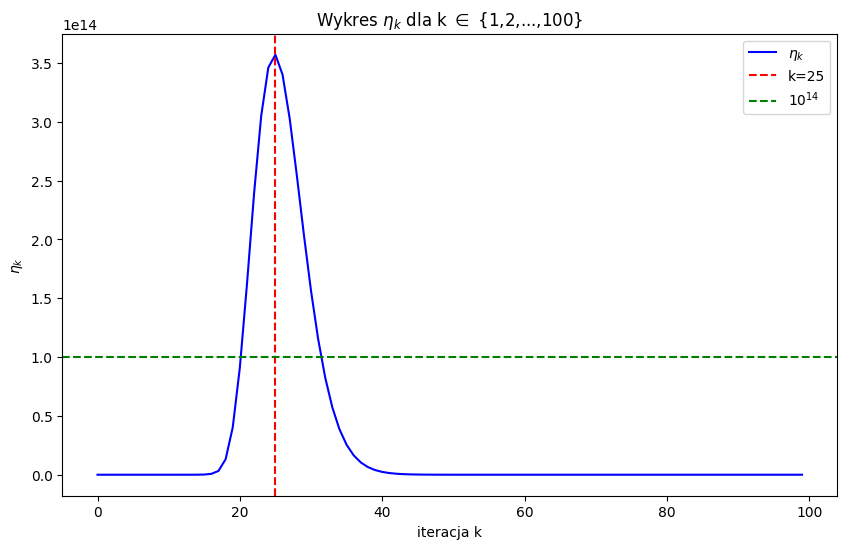

In [ ]:
n = 20
increase = 0.025
k=10**2

#konstrukcja macierzy B
B = np.zeros((n,n))
for i in range(n):
    B[i,i] = increase*(i+1)
    if i < n-1:
        B[i,i+1] = 5

eta_k = np.zeros(k)
diff = np.zeros(k)
x_0 = np.ones((n,1))
x_k = x_0.copy()

for i in range(k):
    x_k = matmul(B,x_k)
    eta_k[i] = vector_norm(x_k)/vector_norm(x_0)
    diff[i] = vector_norm(x_k)<vector_norm(x_0)


plt.figure(figsize=(10, 6))
plt.plot(range(k), eta_k, color='b', label=r'$\eta_k$')
plt.axvline(np.argmax(eta_k), color='r', linestyle='--', label="k={}".format(np.argmax(eta_k)))
plt.axhline( 1e14, color='g', linestyle='--', label='$10^{14}$')
plt.xlabel('iteracja k')
plt.ylabel('$\eta_k$')
plt.title('Wykres $\eta_k$ dla k $\in$ {1,2,...,100}')
plt.legend()
plt.show()

Na powyższym wykresie widać, że z początku wartości $\eta_k$ rosną, a dopiero dla $k=26$ zaczynają znowu maleć.

Najmniejsza wartość k, dla której $||x^{(k)}||_2 < ||x^{(0)}||_2 $ wynosi $85$, co wykazuje poniższy kod.

In [ ]:
print(np.argmax(diff))

85
